# Worksheet 13: Classifiers as an Important Class of Predictive Models

#### Lecture and Tutorial Learning Goals:
After completing this week's lecture and tutorial work, you will be able to:

1. Give an example of a research question that requires a predictive model to predict classes on new observations.
2. Explain the trade-offs between model-based and non-model based approaches, and describe situations where each might be the preferred approach.
3. Write a computer script to perform model selection using ridge and LASSO regressions to fit a logistic regression useful for predictive modeling.
4. List model metrics that are suitable to evaluate predicted classes given by a predictive model with binary responses (e.g., Accuracy, Precision, Sensitivity, Specificity, Cohen's kappa).
5. Write a computer script to compute these model metrics. Interpret and communicate the results from that computer script.

In [1]:
# Run this cell before continuing.
library(tidyverse)
library(repr)
library(infer)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
source("tests_worksheet_13.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var



Attaching package: ‘boot’


The following object is masked from ‘package:lattice’:

    melano

## Predicting classes

In previous weeks, we have focused more on the inferential aspects of the models. This week, we are switching our focus to prediction since in many situations the inference is not a priority. 

When diagnosing a disease, a doctor obtains the patient's medical history and some contextual information (e.g., profession, age, has the patient travelled abroad? etc.), wich combined with some tests results, allows the doctor to make a diagnosis. 

A priori, the patient doesn't care how exactly the doctor made the diagnosis. For example, did the doctor give more importance to the patient's age? or maybe to the result of a blood test? or even a complex combination of those two? Whatever! As long as the diagnosis is correct.

However, to analyze whether the doctor's process (or *model*) to make the diagnosis is reliable, we must consider different aspects. For example,

- Is the doctor able to positively diagnose a high percentage of sick patients? (*sensitivity*)
- Is the doctor able to correctly identify a high percentage of non-sick patients? (*specificity*)
- If the doctor says that a patient is sick, is there a high chance that the patient is sick? (*precision*)
- Considering all the doctor's positive and negative diagnoses, is the doctor right in most cases? (*accuracy*)

At first glance, looking at all these aspects might look redundant. But let's try to understand why it is not. 

For example, 

- If the doctors always said a patient was sick, all the sick patients would be diagnosed. Therefore, the doctor would have great *sensitivity*. However, this doesn't seem very helpful, right? This would be reflected by the doctor's precision.
- On the other hand, if the doctor only diagnoses patients as sick if there's overwhelming evidence, then the *precision* would be quite high. However, the *sensitivity* would be low, i.e., many sick patients wouldn't be diagnosed.
- Imagine a very rare disease. Say 1 case in 100K people. If the doctor always says that the patient is not sick of that disease, then the accuracy will still be pretty high because the part he is getting wrong is quite small. Nonetheless, quite important! 

We are going to define these metrics later in the worksheet; this is just a motivation to show you that, for classification problems, only one metric might not be enough to give you the whole picture. 

## 1. Prediction in Logistic Regression

In the previous week, we introduced logistic regression as a generative model for binary responses. We have already used this model for inferential purposes. Nonetheless, this model can also be used for predictions, i.e., using an estimated logistic model (via a training set) to classify new observations from a test set. 

To check prediction accuracy in classification, we cannot use metrics such as the **Root Mean Squared Error (R-MSE)** as in ordinary least squares (OLS) regression (check `worksheet_09` and `tutorial_09`). Therefore, this worksheet will introduce new metrics meant for logistic regression.

#### Dataset

For this worksheet, we will use the data frame `breast_cancer`. It is the Wisconsin Diagnostic Breast Cancer dataset ([Mangasarian et al., 1995](http://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwlV1Nb9QwEB2xPSA4tHQLohRKDoDgsDSJndiRKlApVBx74PNk2bGDKui2jbf8Ff4uM46tbpZKFZdIO55NvNLLeLx-8waAla_z2UpMEAZXtlZKzllZGSk7WTBdtDa3ts6N61aoOnUqjSGWZaAJhkN9zJfML7dHCi-yfnt-MaPmUXTIGjtpTGAi2cDr-rKkvFsPbQwYBpyafxsvQMTDbPEOVxE5yQSH8iZKHH2iKv4TrsMadLQBKk03kU9WagPHAo___7vuwXpMT7ODAU-bcMvNp3A7seOnsJG6QGQxKEzh7pKk4RQ2o91nL6Oi9ast-LN_qvufb94RAX6xvxc-ZIPtkFDXj23vB_rfiR-b9dxmx_3ZdUO_T_TYgFtsfIXHtuOBinaK84wD9-Hz0YdPhx9nsSPEDPeBJWmp6pJ3VS1tzlvR8Ua6WljWlm3RaMkMs52R1jmJWGu4a6wwtugaaauGtQWaH8Da_GzuHkJWVlpwbgpthKOz3aZsmeRWC9mJxnG7DS8STNT5IPyhaMOEO0xF_WkUZ4qrSuTomEB0k-MzgpiK3UXx4un_F_9DX3qvDjCPw2yPMbxfcCPwLXrd6lgngdMmqa5lx6cJqyoiNTzQLz3xeRq4YWZbAYxXXgGJ27CT8K5iZPOqJEFAUnl8dP2XduDOUPVPjObHsLboL92TIGmxCxPx9TteMcDshnf0L2aRR50)). It has a **binary** response `target`: whether the tumour is `benign` or `malignant`. Hence, the binary response $Y_i$ is mathematically set as:

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th tumour is malignant},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
$$

The data frame `breast_cancer` contains 569 observations from a digitized image of a breast mass' fine needle aspirate (FNA). The dataset details 30 real-valued characteristics (i.e., continuous input variables) plus the binary response and ID number. **We will only work with 16 input variables**.

In [2]:
breast_cancer <- read_csv("data/breast_cancer.csv") %>%
  select(-c(
    mean_area, area_error, concavity_error, concave_points_error, worst_radius, worst_texture, worst_perimeter,
    worst_area, worst_smoothness, worst_compactness, worst_concavity, worst_concave_points, worst_symmetry,
    worst_fractal_dimension
  ))

Rows: 569 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): target
dbl (31): ID, mean_radius, mean_texture, mean_perimeter, mean_area, mean_smo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(breast_cancer)

ID mean_radius mean_texture mean_perimeter mean_smoothness mean_compactness
1 0  17.99       10.38        122.80         0.11840         0.27760         
2 1  20.57       17.77        132.90         0.08474         0.07864         
3 2  19.69       21.25        130.00         0.10960         0.15990         
4 3  11.42       20.38         77.58         0.14250         0.28390         
5 4  20.29       14.34        135.10         0.10030         0.13280         
6 5  12.45       15.70         82.57         0.12780         0.17000         
  mean_concavity mean_concave_points mean_symmetry mean_fractal_dimension
1 0.3001         0.14710             0.2419        0.07871               
2 0.0869         0.07017             0.1812        0.05667               
3 0.1974         0.12790             0.2069        0.05999               
4 0.2414         0.10520             0.2597        0.09744               
5 0.1980         0.10430             0.1809        0.05883               
6 0.1578         0.08089             0.2087        0.07613               
  radius_error texture_error perimeter_error smoothness_error compactness_error
1 1.0950       0.9053        8.589           0.006399         0.04904          
2 0.5435       0.7339        3.398           0.005225         0.01308          
3 0.7456       0.7869        4.585           0.006150         0.04006          
4 0.4956       1.1560        3.445           0.009110         0.07458          
5 0.7572       0.7813        5.438           0.011490         0.02461          
6 0.3345       0.8902        2.217           0.007510         0.03345          
  symmetry_error fractal_dimension_error target   
1 0.03003        0.006193                malignant
2 0.01389        0.003532                malignant
3 0.02250        0.004571                malignant
4 0.05963        0.009208                malignant
5 0.01756        0.005115                malignant
6 0.02165        0.005082                malignant

**Question 1.0**
<br>{points: 1}

Replace the levels `benign` and `malignant` for `target` in the dataset `breast_cancer_train` with the numerical values `1` and `0`, respectively.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [4]:
# breast_cancer <- 
#     breast_cancer %>% 
#     ...(... = ...(..., 1, 0))

# your code here
breast_cancer <- 
    breast_cancer %>% 
    mutate(target = if_else(target == "malignant", 1, 0))

head(breast_cancer)

ID mean_radius mean_texture mean_perimeter mean_smoothness mean_compactness
1 0  17.99       10.38        122.80         0.11840         0.27760         
2 1  20.57       17.77        132.90         0.08474         0.07864         
3 2  19.69       21.25        130.00         0.10960         0.15990         
4 3  11.42       20.38         77.58         0.14250         0.28390         
5 4  20.29       14.34        135.10         0.10030         0.13280         
6 5  12.45       15.70         82.57         0.12780         0.17000         
  mean_concavity mean_concave_points mean_symmetry mean_fractal_dimension
1 0.3001         0.14710             0.2419        0.07871               
2 0.0869         0.07017             0.1812        0.05667               
3 0.1974         0.12790             0.2069        0.05999               
4 0.2414         0.10520             0.2597        0.09744               
5 0.1980         0.10430             0.1809        0.05883               
6 0.1578         0.08089             0.2087        0.07613               
  radius_error texture_error perimeter_error smoothness_error compactness_error
1 1.0950       0.9053        8.589           0.006399         0.04904          
2 0.5435       0.7339        3.398           0.005225         0.01308          
3 0.7456       0.7869        4.585           0.006150         0.04006          
4 0.4956       1.1560        3.445           0.009110         0.07458          
5 0.7572       0.7813        5.438           0.011490         0.02461          
6 0.3345       0.8902        2.217           0.007510         0.03345          
  symmetry_error fractal_dimension_error target
1 0.03003        0.006193                1     
2 0.01389        0.003532                1     
3 0.02250        0.004571                1     
4 0.05963        0.009208                1     
5 0.01756        0.005115                1     
6 0.02165        0.005082                1

In [5]:
test_1.0()

Test passed 🥇
Test passed 🎊
Test passed 🥇
Test passed 😀
Test passed 🥳
[1] "Success!"


**Question 1.1**
<br>{points: 2}

Since we will work with predictive modelling, let us use the *holdout method* in `breast_cancer` to produce two datasets: one for training and another for testing. Therefore, start by randomly splitting `breast_cancer` in two sets on a 70-30% basis: `breast_cancer_train` (70% of the data) and `breast_cancer_test` (the remaining 30%). You can do the following:

1. Use the function [`slice_sample()`](https://dplyr.tidyverse.org/reference/slice.html) to create `breast_cancer_train` (sampling without replacement) with 70\% of the observations coming from `breast_cancer`.
2. Use [`anti_join()`](https://dplyr.tidyverse.org/reference/filter-joins.html) with `breast_cancer` and `breast_cancer_train` to create `breast_cancer_test` by column `ID`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [6]:
set.seed(20211130) # Do not change this

# breast_cancer_train <- 
#     ... %>% 
#     ...(prop = ...)

# breast_cancer_test <- 
#     ... %>% 
#     ...(..., by = "ID")

# your code here
breast_cancer_train <- 
    breast_cancer %>% 
    slice_sample(prop = 0.70)

breast_cancer_test <- 
    breast_cancer %>% 
    anti_join(breast_cancer_train, by = "ID")


head(breast_cancer_train)
nrow(breast_cancer_train)

ID  mean_radius mean_texture mean_perimeter mean_smoothness mean_compactness
1 203 13.810      23.75         91.56         0.13230         0.17680         
2 208 13.110      22.54         87.02         0.10020         0.14830         
3 476 14.200      20.53         92.41         0.08931         0.11080         
4  50 11.760      21.60         74.72         0.08637         0.04966         
5 257 15.320      17.27        103.20         0.13350         0.22840         
6 524  9.847      15.68         63.00         0.09492         0.08419         
  mean_concavity mean_concave_points mean_symmetry mean_fractal_dimension
1 0.15580        0.09176             0.2251        0.07421               
2 0.08705        0.05102             0.1850        0.07310               
3 0.05063        0.03058             0.1506        0.06009               
4 0.01657        0.01115             0.1495        0.05888               
5 0.24480        0.12420             0.2398        0.07596               
6 0.02330        0.02416             0.1387        0.06891               
  radius_error texture_error perimeter_error smoothness_error compactness_error
1 0.5648       1.9300        3.909           0.008824         0.031080         
2 0.1931       0.9223        1.491           0.005251         0.030410         
3 0.3478       1.0180        2.749           0.004107         0.032880         
4 0.4062       1.2100        2.635           0.005857         0.009758         
5 0.6592       1.0590        4.061           0.010150         0.045880         
6 0.2498       1.2160        1.976           0.008732         0.020420         
  symmetry_error fractal_dimension_error target
1 0.01998        0.004506                1     
2 0.02514        0.004198                0     
3 0.01610        0.002744                0     
4 0.02406        0.001769                0     
5 0.01884        0.008660                1     
6 0.01824        0.003494                0

[1] 398

In [7]:
test_1.1_partI()

Test passed 🥇
Test passed 🎊
Test passed 😀
Test passed 😸
Test passed 🎉
[1] "Success!"


In [8]:
test_1.1_partII()

Test passed 🥳
Test passed 😸
Test passed 🌈
Test passed 🥇
Test passed 😸
[1] "Success!"


In [9]:
# Run this cell to remove the variable "ID"

breast_cancer_train <- breast_cancer_train  %>% select(-ID)
breast_cancer_test <- breast_cancer_test  %>% select(-ID)

**Question 1.2**
<br>{points: 1}

Using the `glm` function, fit a logistic regression model. The model's response will be `target` and the rest of the variables will be inputs. Call the resulting object `breast_cancer_logistic_model`.

**Note**: You need to write most of this code cell. Go back to `worksheet_12` if you don't recall how to fit a logistic model.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [10]:
# breast_cancer_logistic_model <- 
#     ...

# your code here
breast_cancer_logistic_model <- 
    glm(
        formula = target ~ .,
        data = breast_cancer_train,
        family = binomial)

summary(breast_cancer_logistic_model)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = target ~ ., family = binomial, data = breast_cancer_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.94258  -0.06390  -0.01147   0.00045   2.64793  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -59.9473    16.5680  -3.618 0.000297 ***
mean_radius                -2.0510     5.8792  -0.349 0.727201    
mean_texture                0.5276     0.1226   4.302 1.69e-05 ***
mean_perimeter              0.5281     0.9127   0.579 0.562828    
mean_smoothness            73.4586    61.3718   1.197 0.231328    
mean_compactness          -57.8241    44.6190  -1.296 0.194991    
mean_concavity             33.6475    13.4299   2.505 0.012231 *  
mean_concave_points        51.4914    47.9337   1.074 0.282724    
mean_symmetry              13.2485    22.0960   0.600 0.548780    
mean_fractal_dimension    355.6678   183.7044   1.936 0.052857 .  
radius_error               16.4094    10.560

In [11]:
test_1.2()

Test passed 🥇
Test passed 🎉
Test passed 🥇
[1] "Success!"


### 1.1 Error in classification

We know that the predicted value of the logistic regression is a predicted probability $\hat{p}_i$

> or the predicted odds or log-odds 

The predicted probability can be used to predict a class. For example, if the predicted probability of having cancer is 0.8, you can predict that the patient has cancer. These models are also known as *classifiers* since you use them to predict a *class*.

For example: 

$$
\hat{Y}_i =
\begin{cases}
1 \; \; \; \; \mbox{if $\hat{p}_i \geq 0.5$},\\
0 \; \; \; \; \mbox{if $\hat{p}_i < 0.5$.}
\end{cases}
$$

where $0.5$ is a threshold used to predict the classes.

Of course, this is only a prediction and the patient may not actually have cancer. The difference between the actual and the predicted class is the *error* of the classifier.

**Question 1.3**
<br>{points: 1}

Let’s start by checking our misclassification error rate in the training data. 

Your job is to create a function with two input arguments: `y` (the actual class of the data points) and `p.hat` (the predicted probability). 

- using $0.5$ as a cut-off, the function predicts the class of each observation based on the predicted probabilty `p.hat`

- the predicted class is then compared to the actual class to calculate the proportion of misclassification in the sample. 

> note that a different cutoff can be used depending on the context of the problem

Use the created function with response variable `target` from `breast_cancer_train` and the (in-sample) predicted values from the model. Store the output in an object named `error_rate_train`.


*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [12]:
# misclassification_rate <- function(y, p.hat){
#     y_hat <- round(..., 0)
#     error_rate <- ...(abs(... - ...))
#     return(error_rate)
# }

# error_rate_train <- 
#     misclassification_rate(
#         ..., 
#         ...)

# your code here
misclassification_rate <- function(y, p.hat){
    y_hat <- round(p.hat, 0)
    error_rate <- mean(abs(y_hat - y))
    return(error_rate)
}

error_rate_train <- 
    misclassification_rate(
        breast_cancer_train$target, 
        predict(breast_cancer_logistic_model, newdata = breast_cancer_train, type = "response"))

error_rate_train

[1] 0.03266332

In [13]:
test_1.3()

Test passed 🎉
Test passed 🥇
Test passed 😸
[1] "Success!"


**Question 1.4**
<br>{points: 1}

The training error rate you calculated in the previous exercise will probably underestimate the out-of-sample error (i.e., the error of data never seen by your model). The parameters were estimated based on that same data!! 

We can estimate the *out-of-sample* error rate by using cross-validation. Use the function `cv.glm`, from the package `boot`, to conduct a 10-fold cross-validation. The arguments of this function are:

- `glmfit`: the trained model that will be used to predict

- `data`: the (test) data you want to predict (not to train the model)

- `K`: number of folds for cross-validation

- `cost`: function to measure error. For this question, use `misclassification_rate`. 

**Note**: note that in this question the test and the training set used are the same since you are computing the confusion matrix for predictions of the training set.

Store the output of the `cv.glm` in an object called `cv_logistic`.

In [14]:
set.seed(20211130) # do not change this

# cv_logistic <- 
#     cv.glm(
#         glmfit = ..., 
#         data = ..., 
#         K = ..., 
#         cost = ...)

# your code here
cv_logistic <- 
    cv.glm(
        glmfit = breast_cancer_logistic_model, 
        data = breast_cancer_train, 
        K = 10, 
        cost = misclassification_rate)


cv_logistic$delta[1]

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 0.05527638

In [15]:
test_1.4()

Test passed 😸
Test passed 🌈
Test passed 🥇
[1] "Success!"


**Question 1.5**
<br>{points: 1}

True or false?

The training error is less than the 10-fold cross validation error.

_Assign your answer to an object called `answer1.5`. Your answer should be either "true" or "false", surrounded by quotes._

In [16]:
# answer1.5 <- ...

# your code here
answer1.5 <- "true"

In [17]:
test_1.5()

Test passed 😸
Test passed 🥇
Test passed 🎉
[1] "Success!"


**Question 1.6**
<br>{points: 1}

True or false?

The training error will **always** be lower than the cross-validation error. 

_Assign your answer to an object called `answer1.6`. Your answer should be either "true" or "false", surrounded by quotes._

In [18]:
# answer1.6 <- ...

# your code here
answer1.6 <- "false"

In [19]:
test_1.6()

Test passed 🥇
Test passed 🎉
Test passed 🥇
[1] "Success!"


### 1.2 Prediction Performance

Classifiers can be evaluated using different metrics that compare the actual *versus* the predicted classes in absolute or relative values. 

#### Confusion Matrix

The confusion matrix shows you the types of errors made by the model. 

|  Predicted \ Actual | Success | Failure |
| :-------------: |:-------------:| :-----:|
| **Success** | $\text{TP}$ | $\text{FP}$ |
| **Failure** | $\text{FN}$ | $$\text{TN}$$ |


This matrix has the following case counts:

- **True positive ($\text{TP}$):** the number of observations **correctly predicted as `1`** (*Malignant*) using the threshold. 


- **False positive ($\text{FP}$):** the number observations **incorrectly predicted as `1`** (*Malignant*) when they are in fact 0.


- **True negative ($\text{TN}$):** the number of observations in **correctly predicted as `0`** (*Benign*).


- **False negative ($\text{FN}$):** the number of observations in  **incorrectly predicted as `0`** (*Benign*) when in fact they are 1. 

> The confusion matrix is usually calculated based on *test* data since that is the primary goal of prediction. 

Luckily for us, the `confusionMatrix()` function from the package `caret` gives us the confusion matrix and other quantities to evaluate classifier. 

#### Sensitivity and Specificity

While the previous measures are all absolute error counts, we can also define relative measures:


- **Sensitivity ($\text{SN}$):** the number of **correct** success predictions divided by the total number of real successes ($\text{S}$), in other words, it is the estimated probability of predicting 1 given that the true class is 1.
$$\text{SN} = \frac{\text{TP}}{\text{TP} + \text{FN}} = \frac{\text{TP}}{\text{S}}$$
    - *Example: the probability that a blood test is positive for a sick  patient.*


- **Specificity ($\text{SP}$):** the number of **correct** failure predictions divided by the total number of real failures ($\text{F}$). In other words, it is the estimated probability of predicting 0 given that the true class is 0.
$$\text{SP} = \frac{\text{TN}}{\text{TN} + \text{FP}} = \frac{\text{TN}}{\text{F}}$$
    - *Example: the probability that a blood test is negative for a healthy  patient.*
    
#### Other common measures

- **Precision ($\text{PR}$):** the number of **correct** success predictions divided by the total number of predicted successes.
$$\text{PR} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$
    - *Example: the probability that a patient is sick if the blood test is positive.*


- **Accuracy ($\text{ACC}$):** the number of **correct** predictions (both success and failure) divided by the total number of observations ($n$).
$$\text{ACC} = \frac{\text{TP} + \text{TN}}{n}$$
    - *Example: the probability that the blood test correctly classifies the patient.*


- **Cohen's Kappa ($\kappa$):** It is another accuracy metric adjusted by how often the predictions and actual classification coincide just by chance. We compute it as:

$$\kappa = \frac{\text{ACC} - \text{AGG}}{1 - \text{AGG}}.$$

For $\kappa$, the random agreement is defined as

$$\text{AGG} = \frac{\text{TP} + \text{FP}}{n} \times \frac{\text{TP} + \text{FN}}{n} + \frac{\text{FN} + \text{TN}}{n} \times \frac{\text{FP} + \text{TN}}{n}.$$

> **Heads-up:** All the metrics above (except $\kappa$) have a range between $0$ and $1$, where values close to $1$ indicate good predictive performance. 

> In the case of $\kappa$, it ranges between $-1$ and $1$ where values close to $1$ indicate good predictive performance.

**Question 1.7**
<br>{points: 1}

To compute the confusion matrix for the classifier built from the estimated logistic regression `breast_cancer_logistic_model`, we need to obtain predicted classes. 

Use the `predict` function to obtain the predicted classes for the training set `breast_cancer_train` and store them in a variable called `breast_cancer_pred_class`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [20]:
# breast_cancer_pred_class <- 
#   ...

# your code here
breast_cancer_pred_class <- 
  predict(breast_cancer_logistic_model, newdata = breast_cancer_train, type = "response") |>
  round(0)

head(breast_cancer_pred_class, 10)

1  2  3  4  5  6  7  8  9 10 
 1  1  0  0  1  0  0  0  0  1

In [21]:
test_1.7()

Test passed 😸
Test passed 🥳
Test passed 😀
[1] "Success!"


**Question 1.8**
<br>{points: 1}

The arguments of the `confusionMatrix()` function are:

- `data`: factor with the predicted classes (use `as.factor()`).
- `reference`: factor with the real classes (use `as.factor()`).
- `positive`: the level considered positive (as a character). 

Store the output of `confusionMatrix` in an object called `breast_cancer_confusion_matrix`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [22]:
# breast_cancer_confusion_matrix <- 
#     ...(
#     data = as.factor(...),
#     reference = as.factor(...),
#     positive = ...
# )

# your code here
breast_cancer_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(breast_cancer_pred_class), 
    reference = as.factor(breast_cancer_train$target),
    positive = "1"
)

breast_cancer_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 254   8
         1   5 131
                                          
               Accuracy : 0.9673          
                 95% CI : (0.9448, 0.9825)
    No Information Rate : 0.6508          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9278          
                                          
 Mcnemar's Test P-Value : 0.5791          
                                          
            Sensitivity : 0.9424          
            Specificity : 0.9807          
         Pos Pred Value : 0.9632          
         Neg Pred Value : 0.9695          
             Prevalence : 0.3492          
         Detection Rate : 0.3291          
   Detection Prevalence : 0.3417          
      Balanced Accuracy : 0.9616          
                                          
       'Positive' Class : 1               
                              

In [23]:
test_1.8()

Test passed 😸
Test passed 🥇
[1] "Success!"


#### Threshold

Note that the *sensitivity* (or *specificity*) of our model depends on the threshold used to predict the classes. 

So far, we have predicted $\hat{y}_i = 1$ if the predicted probability, $\hat{p}_i$, was higher than 50%. But we can also use other values, like 30%, 10%, or 90%. 

**Question 1.9**
<br>{points: 1}

What do you expect to happen if you decrease the threshold from 0.5 to 0.4.

A. Both the specificity and sensitivity would stay the same.

B. Both the specificity and sensitivity would increase.

C. Both the specificity and sensitivity would decrease.

D. The specificity would increase and sensitivity would decrease.

E. The specificity would decrease and sensitivity would increase.

F. There's no way to tell. 

_Assign your answer to an object called `answer1.9`. Your answer should be a single character surrounded by quotes._

In [24]:
# answer1.9 <- ...

# your code here
answer1.9 <- "E"


In [25]:
test_1.9()

Test passed 🎉
Test passed 🎉
Test passed 😀
[1] "Success!"


**Question 1.10**
<br>{points: 1}

Let's change our confusion matrix from the previous question by adjusting the threshold to $p_0 = 0.3$. 


1. Update your predictions using the new threshold and store it in an object named `breast_cancer_pred_class_threshold_0.3`.


2. Use the `confusionMatrix` function to obtain the confusion matrix and associated quantities. Save the output in an object named `confusion_matrix_threshold_0.3`.


*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [26]:
# p_0 <- ...

# breast_cancer_pred_class_threshold_0.3 <- 
#   as.interger(...(..., type = ...) > ...)

# confusion_matrix_threshold_0.3 <- 
#     ...(
#     ...,
#     ...,
#     ...)

#confusion_matrix_threshold_0.3

# your code here
p_0 <- 0.3

breast_cancer_pred_class_threshold_0.3 <- 
  as.integer(predict(breast_cancer_logistic_model, newdata = breast_cancer_train, type = "response") > p_0)

confusion_matrix_threshold_0.3 <- 
    confusionMatrix(
    data = as.factor(breast_cancer_pred_class_threshold_0.3), 
    reference = as.factor(breast_cancer_train$target),
    positive = "1")


confusion_matrix_threshold_0.3

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 249   5
         1  10 134
                                          
               Accuracy : 0.9623          
                 95% CI : (0.9386, 0.9788)
    No Information Rate : 0.6508          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9178          
                                          
 Mcnemar's Test P-Value : 0.3017          
                                          
            Sensitivity : 0.9640          
            Specificity : 0.9614          
         Pos Pred Value : 0.9306          
         Neg Pred Value : 0.9803          
             Prevalence : 0.3492          
         Detection Rate : 0.3367          
   Detection Prevalence : 0.3618          
      Balanced Accuracy : 0.9627          
                                          
       'Positive' Class : 1               
                              

In [27]:
test_1.10()

Test passed 🎊
Test passed 🥇
[1] "Success!"


Was this what you expected?

### AUC and ROC 

A limitation of the approach taken in the previous question is that the evaluation of the classifier depends critically on the threshold $p_0$, but the most appropriate choice of $p_0$ may not be clear. 

Alternatively, we can evaluate the predictive performance of a given classifier for all possible value of $p_0 \in [0, 1]$. The resulting curve is known as the *receiver operating characteristic* (ROC) curve. 

The *area under the curve* (AUC) measures the classification ability of the classifier. The AUC goes from $0$ to $1$. 

> the higher the AUC, the better predictive performance!!

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/440px-Roc_curve.svg.png)

**Question 1.11**
<br>{points: 1}

The package `pROC`, via its function `roc()`, plots ROC curves. You need to specify the real observed classes in the argument `response` and the predictions in `predictor`. 

Using `breast_cancer_train` create the ROC curve for `breast_cancer_logistic_model` and call it `ROC_full_log`. Then, use `plot()` to display it.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

Setting levels: control = 0, case = 1

Setting direction: controls < cases



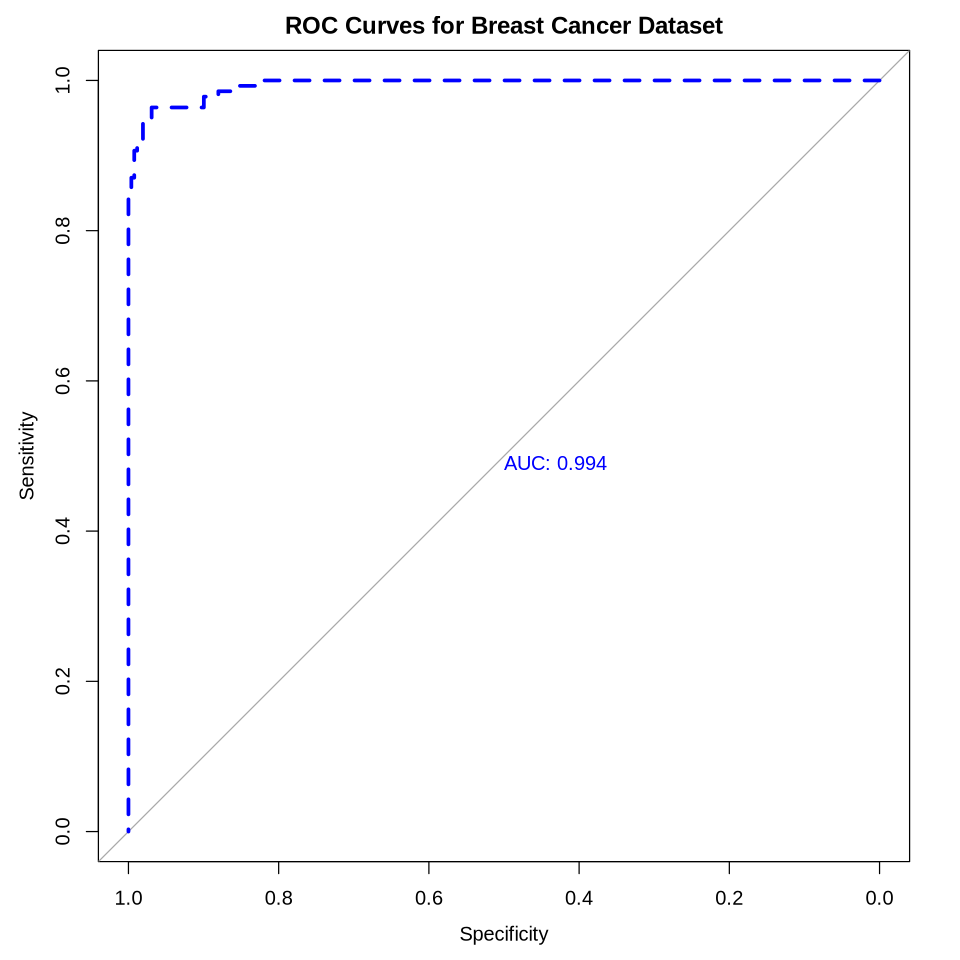

In [28]:
options(repr.plot.width = 8, repr.plot.height = 8) # Adjust these numbers so the plot looks good in your desktop.

# ROC_full_log <- roc(
#   response = ...,
#   predictor = ...
# )
# plot(...,
#   print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
#   main = "ROC Curves for Breast Cancer Dataset"
# )

# your code here
ROC_full_log <- roc(
  response = breast_cancer_train$target,
  predictor = predict(breast_cancer_logistic_model, newdata=breast_cancer_train, type = "response")
)
plot(ROC_full_log,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Breast Cancer Dataset"
)

In [29]:
test_1.11()

Test passed 🎉
Test passed 😸
[1] "Success!"


One last comment for this worksheet is that here we have used the training data to obtain the confusion matrix. As we know, the training data will most probably be underestimating our error. A much better approach would be to use a cross-validation or the test set to make a similar analysis. 

We abstained from this step to focus on the concepts but, in the tutorial, we will use cross-validation to evaluate the prediction accuracy of different classifiers.